In [1]:
import brian2
from brian2 import *
import matplotlib
%matplotlib inline



Bad key "text.kerning_factor" on line 4 in
/opt/anaconda3/envs/untitled2/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


# <center> <font color=red>**Brian 2 introduction**</font>  </center> 

# Part 1 : Introduction

## Unit system

Brian has a system for using quantities with physical dimensions:



In [3]:
20*volt


20. * volt

#### All of the basic SI units can be used (volt, amp, etc.) along with all the standard prefixes (m=milli, p=pico, etc.), as well as a few special abbreviations like mV for millivolt, pF for picofarad, etc.



In [4]:
1000*amp

1. * kamp

In [5]:
1e6*volt

1. * Mvolt

In [6]:
1000*namp

1. * uamp

In [7]:
1000*namp ### Combinaison

1. * uamp

## A simple model

##### Let’s start by defining a simple neuron model. In Brian, all models are defined by systems of differential equations. Here’s a simple example of what that looks like:

In [8]:
start_scope()

tau = 10*ms
eqs = '''
dv/dt = (1-v)/tau : 1
'''

##### Let's create a neuron using this equation

In [9]:
G = NeuronGroup(1, eqs, method="exact")

In Brian, you only create groups of neurons, using the class NeuronGroup. The first two arguments when you create one of these objects are the number of neurons (in this case, 1) and the defining differential equations.


In [10]:
print('Before v = %s' % G.v[0])

run(100*ms)


Before v = 0.0


In [11]:
print('After v = %s' % G.v[0])


After v = 0.9999546000702376


By default, all variables start with the value 0. Since the differential equation is dv/dt=(1-v)/tau we would expect after a while that v would tend towards the value 1, which is just what we see. Specifically, we’d expect v to have the value 1-exp(-t/tau). Let’s see if that’s right.



In [12]:
print('Expected value of v = %s' % (1-exp(-100*ms/tau)))


Expected value of v = 0.9999546000702375


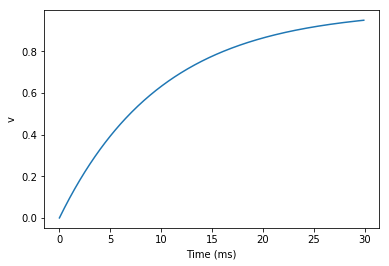

In [13]:
start_scope()

G = NeuronGroup(1, eqs, method='exact')
M = StateMonitor(G, 'v', record=True)

run(30*ms) ## We run for 30 ms

plot(M.t/ms, M.v[0])
xlabel('Time (ms)')
ylabel('v');


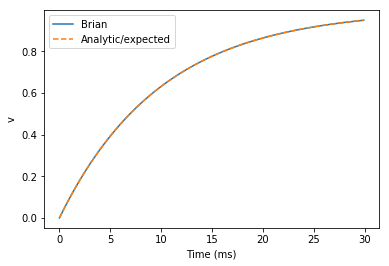

In [14]:
start_scope()

G = NeuronGroup(1, eqs, method='exact')
M = StateMonitor(G, 'v', record=0)

run(30*ms)

plot(M.t/ms, M.v[0], 'C0', label='Brian')
plot(M.t/ms, 1-exp(-M.t/tau), 'C1--',label='Analytic/expected')
xlabel('Time (ms)')
ylabel('v')
legend();

In this example, we used the object StateMonitor object. This is used to record the values of a neuron variable while the simulation runs. The first two arguments are the group to record from, and the variable you want to record from. We also specify record=0. This means that we record all values for neuron 0. We have to specify which neurons we want to record because in large simulations with many neurons it usually uses up too much RAM to record the values of all neurons.

Now try modifying the equations and parameters and see what happens in the cell below.




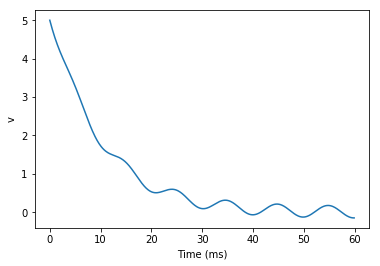

In [15]:
start_scope()

tau = 10*ms
eqs = '''
dv/dt = (sin(2*pi*100*Hz*t)-v)/tau : 1
'''

# Change to Euler method because exact integrator doesn't work here
G = NeuronGroup(1, eqs, method='euler')
M = StateMonitor(G, 'v', record=0)

G.v = 5 # initial value

run(60*ms)

plot(M.t/ms, M.v[0])
xlabel('Time (ms)')
ylabel('v');

### Adding spikes


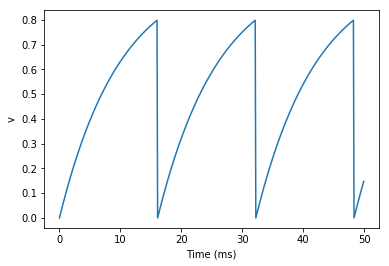

In [16]:
start_scope()

tau = 10*ms
eqs = '''
dv/dt = (1-v)/tau : 1
'''

G = NeuronGroup(1, eqs, threshold='v>0.8', reset='v = 0', method='exact')

M = StateMonitor(G, 'v', record=0)
run(50*ms)
plot(M.t/ms, M.v[0])
xlabel('Time (ms)')
ylabel('v');

We’ve added two new keywords to the NeuronGroup declaration: threshold='v>0.8' and reset='v = 0'. What this means is that when v>0.8 we fire a spike, and immediately reset v = 0 after the spike. We can put any expression and series of statements as these strings.

As you can see, at the beginning the behaviour is the same as before until v crosses the threshold v>0.8 at which point you see it reset to 0. You can’t see it in this figure, but internally Brian has registered this event as a spike. Let’s have a look at that.



In [17]:
start_scope()

G = NeuronGroup(1, eqs, threshold='v>0.8', reset='v = 0', method='exact')

spikemon = SpikeMonitor(G)

run(50*ms)

print('Spike times: %s' % spikemon.t[:])

Spike times: [16.  32.1 48.2] ms


The SpikeMonitor object takes the group whose spikes you want to record as its argument and stores the spike times in the variable t. Let’s plot those spikes on top of the other figure to see that it’s getting it right.

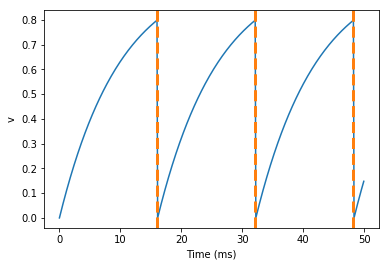

In [18]:
start_scope()

G = NeuronGroup(1, eqs, threshold='v>0.8', reset='v = 0', method='exact')

statemon = StateMonitor(G, 'v', record=0)
spikemon = SpikeMonitor(G)

run(50*ms)

plot(statemon.t/ms, statemon.v[0])
for t in spikemon.t:
    axvline(t/ms, ls='--', c='C1', lw=3)
xlabel('Time (ms)')
ylabel('v');

### Refractoriness


A common feature of neuron models is refractoriness. This means that after the neuron fires a spike it becomes refractory for a certain duration and cannot fire another spike until this period is over. Here’s how we do that in Brian.



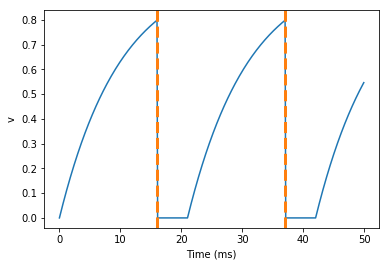

In [19]:
start_scope()

tau = 10*ms
eqs = '''
dv/dt = (1-v)/tau : 1 (unless refractory)
'''

G = NeuronGroup(1, eqs, threshold='v>0.8', reset='v = 0', refractory=5*ms, method='exact')

statemon = StateMonitor(G, 'v', record=0)
spikemon = SpikeMonitor(G)

run(50*ms)

plot(statemon.t/ms, statemon.v[0])
for t in spikemon.t:
    axvline(t/ms, ls='--', c='C1', lw=3)
xlabel('Time (ms)')
ylabel('v');

As you can see in this figure, after the first spike, v stays at 0 for around 5 ms before it resumes its normal behaviour. To do this, we’ve done two things. Firstly, we’ve added the keyword refractory=5*ms to the NeuronGroup declaration. On its own, this only means that the neuron cannot spike in this period (see below), but doesn’t change how v behaves. In order to make v stay constant during the refractory period, we have to add (unless refractory) to the end of the definition of v in the differential equations. What this means is that the differential equation determines the behaviour of v unless it’s refractory in which case it is switched off.

Here’s what would happen if we didn’t include (unless refractory). Note that we’ve also decreased the value of tau and increased the length of the refractory period to make the behaviour clearer.

Spike times: [ 8. 23. 38.] ms


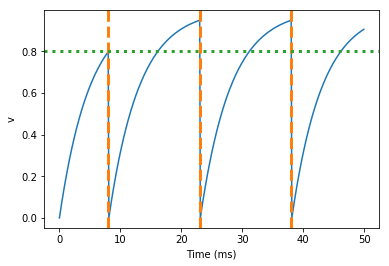

In [20]:
start_scope()

tau = 5*ms
eqs = '''
dv/dt = (1-v)/tau : 1
'''

G = NeuronGroup(1, eqs, threshold='v>0.8', reset='v = 0', refractory=15*ms, method='exact')

statemon = StateMonitor(G, 'v', record=0)
spikemon = SpikeMonitor(G)

run(50*ms)

plot(statemon.t/ms, statemon.v[0])
for t in spikemon.t:
    axvline(t/ms, ls='--', c='C1', lw=3)
axhline(0.8, ls=':', c='C2', lw=3)
xlabel('Time (ms)')
ylabel('v')
print("Spike times: %s" % spikemon.t[:])

### Multiple neurons


So far we’ve only been working with a single neuron. Let’s do something interesting with multiple neurons.


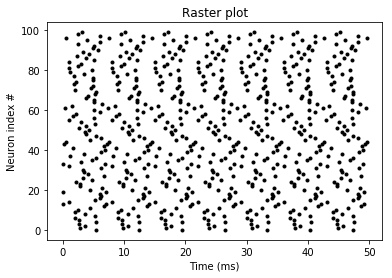

In [21]:
start_scope()

N = 100
tau = 10*ms
eqs = '''
dv/dt = (2-v)/tau : 1
'''

G = NeuronGroup(N, eqs, threshold='v>1', reset='v=0', method='exact')
G.v = 'rand()'

spikemon = SpikeMonitor(G)

run(50*ms)

plot(spikemon.t/ms, spikemon.i, '.k')
xlabel('Time (ms)')
ylabel('Neuron index #')
title('Raster plot');

This shows a few changes. Firstly, we’ve got a new variable N determining the number of neurons. Secondly, we added the statement G.v = 'rand()' before the run. What this does is initialise each neuron with a different uniform random value between 0 and 1. We’ve done this just so each neuron will do something a bit different. The other big change is how we plot the data in the end.

As well as the variable spikemon.t with the times of all the spikes, we’ve also used the variable spikemon.i which gives the corresponding neuron index for each spike, and plotted a single black dot with time on the x-axis and neuron index on the y-value. This is the standard “raster plot” used in neuroscience.



### Parameters

To make these multiple neurons do something more interesting, let’s introduce per-neuron parameters that don’t have a differential equation attached to them.

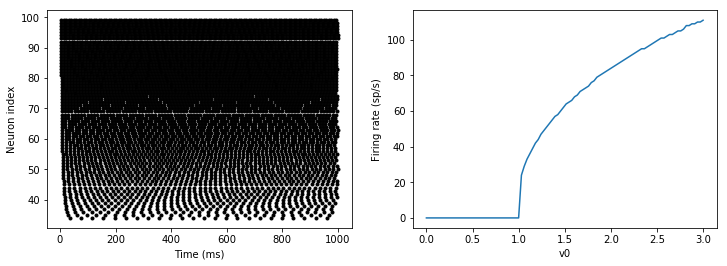

In [22]:
start_scope()

N = 100
tau = 10*ms
v0_max = 3.
duration = 1000*ms

eqs = '''
dv/dt = (v0-v)/tau : 1 (unless refractory)
v0 : 1
'''

G = NeuronGroup(N, eqs, threshold='v>1', reset='v=0', refractory=5*ms, method='exact')
M = SpikeMonitor(G)

G.v0 = 'i*v0_max/(N-1)'

run(duration)

figure(figsize=(12,4))
subplot(121)
plot(M.t/ms, M.i, '.k')
xlabel('Time (ms)')
ylabel('Neuron index')
subplot(122)
plot(G.v0, M.count/duration)
xlabel('v0')
ylabel('Firing rate (sp/s)');


The line v0 : 1 declares a new per-neuron parameter v0 with units 1 (i.e. dimensionless).

The line G.v0 = 'i*v0_max/(N-1)' initialises the value of v0 for each neuron varying from 0 up to v0_max. The symbol i when it appears in strings like this refers to the neuron index.

So in this example, we’re driving the neuron towards the value v0 exponentially, but when v crosses v>1, it fires a spike and resets. The effect is that the rate at which it fires spikes will be related to the value of v0. For v0<1 it will never fire a spike, and as v0 gets larger it will fire spikes at a higher rate. The right hand plot shows the firing rate as a function of the value of v0. This is the I-f curve of this neuron model.

Note that in the plot we’ve used the count variable of the SpikeMonitor: this is an array of the number of spikes each neuron in the group fired. Dividing this by the duration of the run gives the firing rate.

### Stochastic neurons

Often when making models of neurons, we include a random element to model the effect of various forms of neural noise. In Brian, we can do this by using the symbol xi in differential equations. Strictly speaking, this symbol is a “stochastic differential” but you can sort of thinking of it as just a Gaussian random variable with mean 0 and standard deviation 1. We do have to take into account the way stochastic differentials scale with time, which is why we multiply it by tau**-0.5 in the equations below (see a textbook on stochastic differential equations for more details). Note that we also changed the method keyword argument to use 'euler' (which stands for the Euler-Maruyama method); the 'exact' method that we used earlier is not applicable to stochastic differential equations.



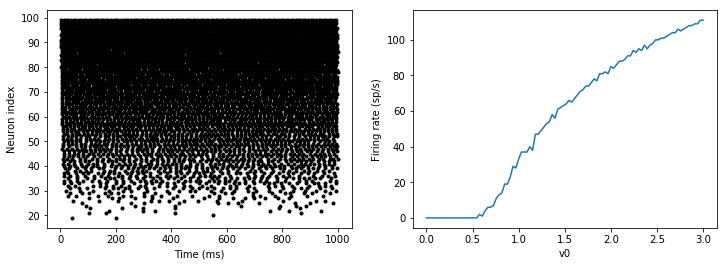

In [23]:
start_scope()

N = 100
tau = 10*ms
v0_max = 3.
duration = 1000*ms
sigma = 0.2

eqs = '''
dv/dt = (v0-v)/tau+sigma*xi*tau**-0.5 : 1 (unless refractory)
v0 : 1
'''

G = NeuronGroup(N, eqs, threshold='v>1', reset='v=0', refractory=5*ms, method='euler')
M = SpikeMonitor(G)

G.v0 = 'i*v0_max/(N-1)'

run(duration)

figure(figsize=(12,4))
subplot(121)
plot(M.t/ms, M.i, '.k')
xlabel('Time (ms)')
ylabel('Neuron index')
subplot(122)
plot(G.v0, M.count/duration)
xlabel('v0')
ylabel('Firing rate (sp/s)');


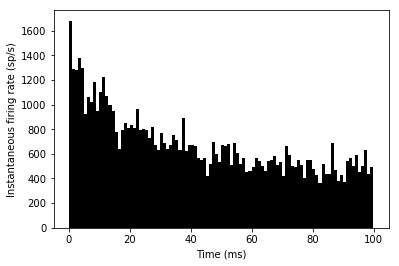

In [24]:
start_scope()

N = 1000
tau = 10*ms
vr = -70*mV
vt0 = -50*mV
delta_vt0 = 5*mV
tau_t = 100*ms
sigma = 0.5*(vt0-vr)
v_drive = 2*(vt0-vr)
duration = 100*ms

eqs = '''
dv/dt = (v_drive+vr-v)/tau + sigma*xi*tau**-0.5 : volt
dvt/dt = (vt0-vt)/tau_t : volt
'''

reset = '''
v = vr
vt += delta_vt0
'''

G = NeuronGroup(N, eqs, threshold='v>vt', reset=reset, refractory=5*ms, method='euler')
spikemon = SpikeMonitor(G)
M = StateMonitor(G, 'v', record=True)


G.v = 'rand()*(vt0-vr)+vr'
G.vt = vt0

run(duration)

_ = hist(spikemon.t/ms, 100, histtype='stepfilled', facecolor='k', weights=ones(len(spikemon))/(N*defaultclock.dt))
xlabel('Time (ms)')
ylabel('Instantaneous firing rate (sp/s)');

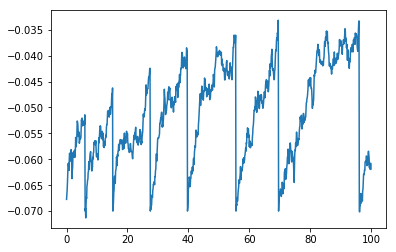

In [25]:
plot(M.t/ms, M.v[0])
### PSTH

# Part 2 : Synapses

## The simplest Synapse


Once you have some neurons, the next step is to connect them up via synapses. We’ll start out with doing the simplest possible type of synapse that causes an instantaneous change in a variable after a spike.


WARNING    "tau" is an internal variable of group "neurongroup", but also exists in the run namespace with the value 10. * msecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


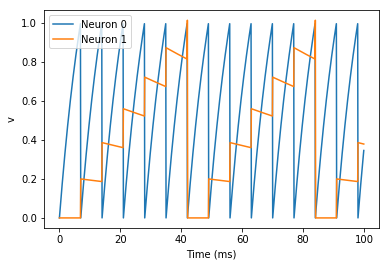

In [26]:
start_scope()

eqs = '''
dv/dt = (I-v)/tau : 1
I : 1
tau : second
'''
G = NeuronGroup(2, eqs, threshold='v>1', reset='v = 0', method='exact')
G.I = [2, 0]
G.tau = [10, 100]*ms

# Comment these two lines out to see what happens without Synapses
S = Synapses(G, G, on_pre='v_post += 0.2')
S.connect(i=0, j=1)

M = StateMonitor(G, 'v', record=True)

run(100*ms)

plot(M.t/ms, M.v[0], label='Neuron 0')
plot(M.t/ms, M.v[1], label='Neuron 1')
xlabel('Time (ms)')
ylabel('v')
legend();

 Neuron 0 has I=2 and tau=10*ms which means that is driven to repeatedly spike at a fairly high rate. Neuron 1 has I=0 and tau=100*ms which means that on its own - without the synapses - it won’t spike at all (the driving current I is 0). You can prove this to yourself by commenting out the two lines that define the synapse.

Next we define the synapses: Synapses(source, target, ...) means that we are defining a synaptic model that goes from source to target. In this case, the source and target are both the same, the group G. The syntax on_pre='v_post += 0.2' means that when a spike occurs in the presynaptic neuron (hence on_pre) it causes an instantaneous change to happen v_post += 0.2. The _post means that the value of v referred to is the post-synaptic value, and it is increased by 0.2. So in total, what this model says is that whenever two neurons in G are connected by a synapse, when the source neuron fires a spike the target neuron will have its value of v increased by 0.2.

However, at this point we have only defined the synapse model, we haven’t actually created any synapses. The next line S.connect(i=0, j=1) creates a synapse from neuron 0 to neuron 1.

### Adding a weight

In the previous section, we hard coded the weight of the synapse to be the value 0.2, but often we would to allow this to be different for different synapses. We do that by introducing synapse equations.



WARNING    "tau" is an internal variable of group "neurongroup_1", but also exists in the run namespace with the value 10. * msecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


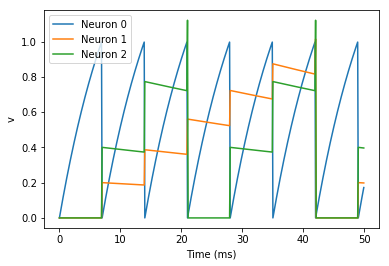

In [27]:
start_scope()


eqs = '''
dv/dt = (I-v)/tau : 1
I : 1
tau : second
'''
G = NeuronGroup(3, eqs, threshold='v>1', reset='v = 0', method='exact')
G.I = [2, 0, 0]
G.tau = [10, 100, 100]*ms

# Comment these two lines out to see what happens without Synapses
S = Synapses(G, G, 'w : 1', on_pre='v_post += w')
S.connect(i=0, j=[1, 2])
S.w = 'j*0.2'

M = StateMonitor(G, 'v', record=True)

run(50*ms)

plot(M.t/ms, M.v[0], label='Neuron 0')
plot(M.t/ms, M.v[1], label='Neuron 1')
plot(M.t/ms, M.v[2], label='Neuron 2')
xlabel('Time (ms)')
ylabel('v')
legend();

This example behaves very similarly to the previous example, but now there’s a synaptic weight variable w. The string 'w : 1' is an equation string, precisely the same as for neurons, that defines a single dimensionless parameter w. We changed the behaviour on a spike to on_pre='v_post += w' now, so that each synapse can behave differently depending on the value of w. To illustrate this, we’ve made a third neuron which behaves precisely the same as the second neuron, and connected neuron 0 to both neurons 1 and 2. We’ve also set the weights via S.w = 'j*0.2'. When i and j occur in the context of synapses, i refers to the source neuron index, and j to the target neuron index. So this will give a synaptic connection from 0 to 1 with weight 0.2=0.2*1 and from 0 to 2 with weight 0.4=0.2*2.



### Introducing a delay

So far, the synapses have been instantaneous, but we can also make them act with a certain delay.


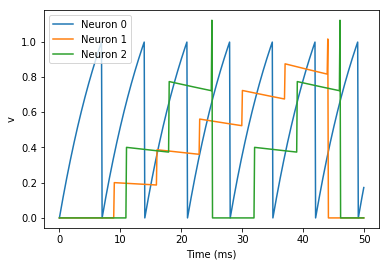

In [28]:
start_scope()

eqs = '''
dv/dt = (I-v)/tau : 1
I : 1
tau : second
'''
G = NeuronGroup(3, eqs, threshold='v>1', reset='v = 0', method='exact')
G.I = [2, 0, 0]
G.tau = [10, 100, 100]*ms

S = Synapses(G, G, 'w : 1', on_pre='v_post += w')
S.connect(i=0, j=[1, 2])
S.w = 'j*0.2'
S.delay = 'j*2*ms'

M = StateMonitor(G, 'v', record=True)

run(50*ms)

plot(M.t/ms, M.v[0], label='Neuron 0')
plot(M.t/ms, M.v[1], label='Neuron 1')
plot(M.t/ms, M.v[2], label='Neuron 2')
xlabel('Time (ms)')
ylabel('v')
legend();

### More complex connectivity

So far, we specified the synaptic connectivity explicitly, but for larger networks this isn’t usually possible. For that, we usually want to specify some condition.

The line S.connect(condition='i!=j', p=0.2) will connect all pairs of neurons i and j with probability 0.2 as long as the condition i!=j holds. So, how can we see that connectivity? Here’s a little function that will let us visualise it.

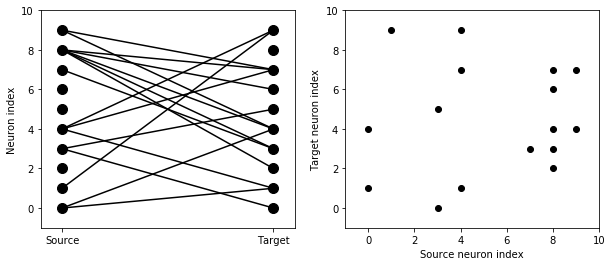

In [29]:
start_scope()

N = 10
G = NeuronGroup(N, 'v:1')
S = Synapses(G, G)
S.connect(condition='i!=j', p=0.2)

def visualise_connectivity(S):
    Ns = len(S.source)
    Nt = len(S.target)
    figure(figsize=(10, 4))
    subplot(121)
    plot(zeros(Ns), arange(Ns), 'ok', ms=10)
    plot(ones(Nt), arange(Nt), 'ok', ms=10)
    for i, j in zip(S.i, S.j):
        plot([0, 1], [i, j], '-k')
    xticks([0, 1], ['Source', 'Target'])
    ylabel('Neuron index')
    xlim(-0.1, 1.1)
    ylim(-1, max(Ns, Nt))
    subplot(122)
    plot(S.i, S.j, 'ok')
    xlim(-1, Ns)
    ylim(-1, Nt)
    xlabel('Source neuron index')
    ylabel('Target neuron index')

visualise_connectivity(S)

There are two plots here. On the left hand side, you see a vertical line of circles indicating source neurons on the left, and a vertical line indicating target neurons on the right, and a line between two neurons that have a synapse. On the right hand side is another way of visualising the same thing. Here each black dot is a synapse, with x value the source neuron index, and y value the target neuron index.

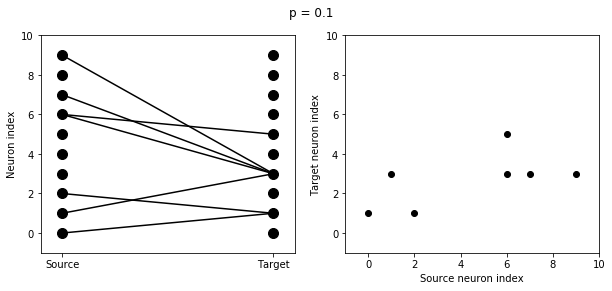

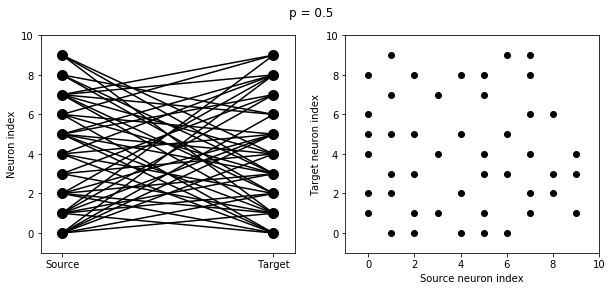

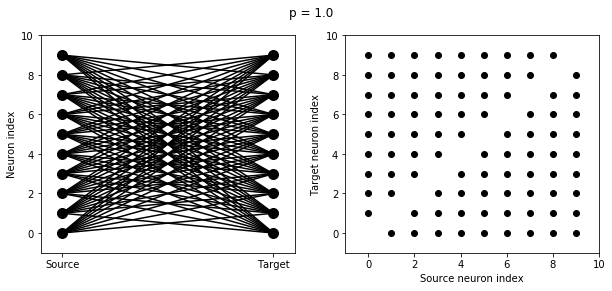

In [30]:
start_scope()

N = 10
G = NeuronGroup(N, 'v:1')

for p in [0.1, 0.5, 1.0]:
    S = Synapses(G, G)
    S.connect(condition='i!=j', p=p)
    visualise_connectivity(S)
    suptitle('p = '+str(p))

And let’s see what another connectivity condition looks like. This one will only connect neighbouring neurons.

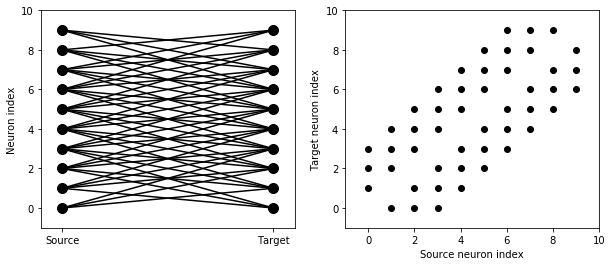

In [31]:
start_scope()

N = 10
G = NeuronGroup(N, 'v:1')

S = Synapses(G, G)
S.connect(condition='abs(i-j)<4 and i!=j')
visualise_connectivity(S)

Note that the following example uses skip_if_invalid to avoid errors at the boundaries (e.g. do not try to connect the neuron with index 1 to a neuron with index -2).

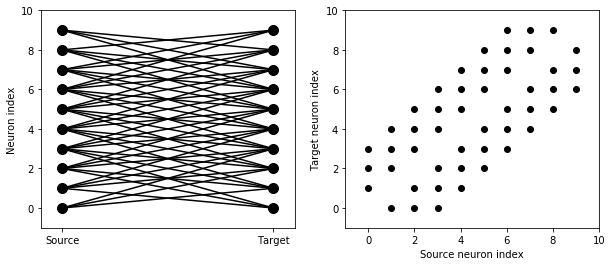

In [32]:
start_scope()

N = 10
G = NeuronGroup(N, 'v:1')

S = Synapses(G, G)
S.connect(j='k for k in range(i-3, i+4) if i!=k', skip_if_invalid=True)
visualise_connectivity(S)

If each source neuron is connected to precisely one target neuron (which would be normally used with two separate groups of the same size, not with identical source and target groups as in this example), there is a special syntax that is extremely efficient. For example, 1-to-1 connectivity looks like this:


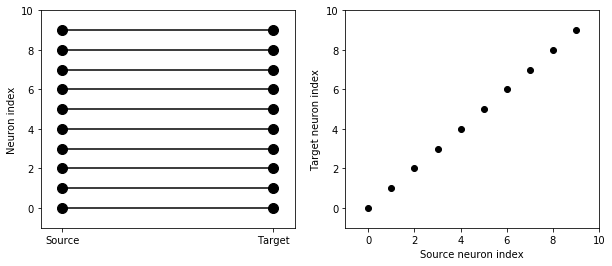

In [33]:
start_scope()

N = 10
G = NeuronGroup(N, 'v:1')

S = Synapses(G, G)
S.connect(j='i')
visualise_connectivity(S)

You can also do things like specifying the value of weights with a string. Let’s see an example where we assign each neuron a spatial location and have a distance-dependent connectivity function. We visualise the weight of a synapse by the size of the marker.


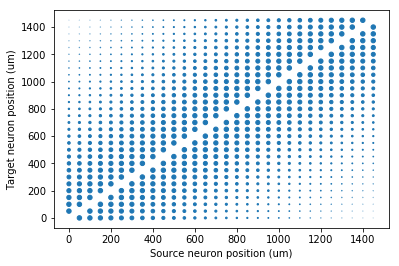

In [34]:
start_scope()

N = 30
neuron_spacing = 50*umetre
width = N/4.0*neuron_spacing

# Neuron has one variable x, its position
G = NeuronGroup(N, 'x : metre')
G.x = 'i*neuron_spacing'

# All synapses are connected (excluding self-connections)
S = Synapses(G, G, 'w : 1')
S.connect(condition='i!=j')
# Weight varies with distance
S.w = 'exp(-(x_pre-x_post)**2/(2*width**2))'

scatter(S.x_pre/um, S.x_post/um, S.w*20)
xlabel('Source neuron position (um)')
ylabel('Target neuron position (um)');

### More complex synapse models: STDP

Brian’s synapse framework is very general and can do things like short-term plasticity (STP) or spike-timing dependent plasticity (STDP). Let’s see how that works for STDP.

STDP is normally defined by an equation something like this:


$$\Delta w =\sum_{t_{pre}}\sum_{t_{post}} W(t_{post}-t_{pre})$$

That is, the change in synaptic weight w is the sum over all presynaptic spike times $t_{pre}$ and postsynaptic spike times $t_{post}$ of some function W of the difference in these spike times. A commonly used function 𝑊 is:

\begin{split}W(\Delta t) = \begin{cases}
A_{pre} e^{-\Delta t/\tau_{pre}} & \Delta t>0 \\
A_{post} e^{\Delta t/\tau_{post}} & \Delta t<0
\end{cases}\end{split}

This function looks like this:



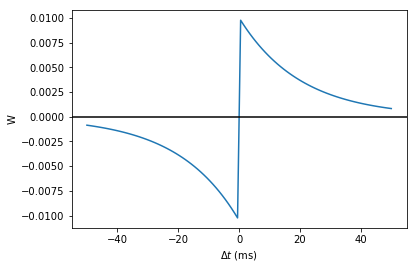

In [35]:
tau_pre = tau_post = 20*ms
A_pre = 0.01
A_post = -A_pre*1.05
delta_t = linspace(-50, 50, 100)*ms
W = where(delta_t>0, A_pre*exp(-delta_t/tau_pre), A_post*exp(delta_t/tau_post))
plot(delta_t/ms, W)
xlabel(r'$\Delta t$ (ms)')
ylabel('W')
axhline(0, ls='-', c='k');

Simulating it directly using this equation though would be very inefficient, because we would have to sum over all pairs of spikes. That would also be physiologically unrealistic because the neuron cannot remember all its previous spike times. It turns out there is a more efficient and physiologically more plausible way to get the same effect.

We define two new variables a_{pre} and a_{post} which are “traces” of pre- and post-synaptic activity, governed by the differential equations:

\begin{split}\begin{align}
\tau_{pre}\frac{\mathrm{d}}{\mathrm{d}t} a_{pre} &= -a_{pre}\\
\tau_{post}\frac{\mathrm{d}}{\mathrm{d}t} a_{post} &= -a_{post}
\end{align}\end{split}

When a presynaptic spike occurs, the presynaptic trace is updated and the weight is modified according to the rule:

\begin{split}\begin{align}
a_{pre} &\rightarrow a_{pre}+A_{pre}\\
w &\rightarrow w+a_{post}
\end{align}\end{split}

When a postsynaptic spike occurs:

\begin{split}\begin{align}
a_{post} &\rightarrow a_{post}+A_{post}\\
w &\rightarrow w+a_{pre}
\end{align}\end{split}

To see that this formulation is equivalent, you just have to check that the equations sum linearly, and consider two cases: what happens if the presynaptic spike occurs before the postsynaptic spike, and vice versa. Try drawing a picture of it.

Now that we have a formulation that relies only on differential equations and spike events, we can turn that into Brian code.



start_scope()

taupre = taupost = 20*ms
wmax = 0.01
Apre = 0.01
Apost = -Apre*taupre/taupost*1.05

G = NeuronGroup(1, 'v:1', threshold='v>1')

S = Synapses(G, G,
             '''
             w : 1
             dapre/dt = -apre/taupre : 1 (event-driven)
             dapost/dt = -apost/taupost : 1 (event-driven)
             ''',
             on_pre='''
             v_post += w
             apre += Apre
             w = clip(w+apost, 0, wmax)
             ''',
             on_post='''
             apost += Apost
             w = clip(w+apre, 0, wmax)
             ''')


There are a few things to see there. Firstly, when defining the synapses we’ve given a more complicated multi-line string defining three synaptic variables (w, apre and apost). We’ve also got a new bit of syntax there, (event-driven) after the definitions of apre and apost. What this means is that although these two variables evolve continuously over time, Brian should only update them at the time of an event (a spike). This is because we don’t need the values of apre and apost except at spike times, and it is more efficient to only update them when needed.

Next we have a on_pre=... argument. The first line is v_post += w: this is the line that actually applies the synaptic weight to the target neuron. The second line is apre += Apre which encodes the rule above. In the third line, we’re also encoding the rule above but we’ve added one extra feature: we’ve clamped the synaptic weights between a minimum of 0 and a maximum of wmax so that the weights can’t get too large or negative. The function clip(x, low, high) does this.

Finally, we have a on_post=... argument. This gives the statements to calculate when a post-synaptic neuron fires. Note that we do not modify v in this case, only the synaptic variables.

Now let’s see how all the variables behave when a presynaptic spike arrives some time before a postsynaptic spike.


WARNING    "t" is an internal variable of group "neurongroup_1", but also exists in the run namespace with the value 38. * msecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


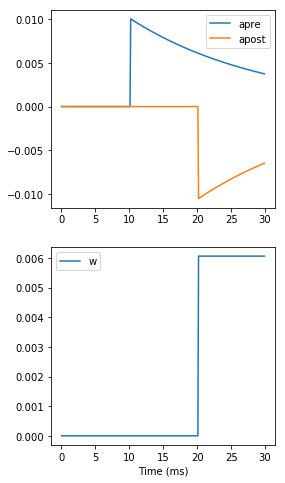

In [36]:
start_scope()

taupre = taupost = 20*ms
wmax = 0.01
Apre = 0.01
Apost = -Apre*taupre/taupost*1.05

G = NeuronGroup(2, 'v:1', threshold='t>(1+i)*10*ms', refractory=100*ms)

S = Synapses(G, G,
             '''
             w : 1
             dapre/dt = -apre/taupre : 1 (clock-driven)
             dapost/dt = -apost/taupost : 1 (clock-driven)
             ''',
             on_pre='''
             v_post += w
             apre += Apre
             w = clip(w+apost, 0, wmax)
             ''',
             on_post='''
             apost += Apost
             w = clip(w+apre, 0, wmax)
             ''', method='linear')
S.connect(i=0, j=1)
M = StateMonitor(S, ['w', 'apre', 'apost'], record=True)

run(30*ms)

figure(figsize=(4, 8))
subplot(211)
plot(M.t/ms, M.apre[0], label='apre')
plot(M.t/ms, M.apost[0], label='apost')
legend()
subplot(212)
plot(M.t/ms, M.w[0], label='w')
legend(loc='best')
xlabel('Time (ms)');

Finally, let’s verify that this formulation is equivalent to the original one.

WARNING    "t" is an internal variable of group "neurongroup_4", but also exists in the run namespace with the value 38. * msecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "t" is an internal variable of group "neurongroup", but also exists in the run namespace with the value 38. * msecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "t" is an internal variable of group "synapses", but also exists in the run namespace with the value 38. * msecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


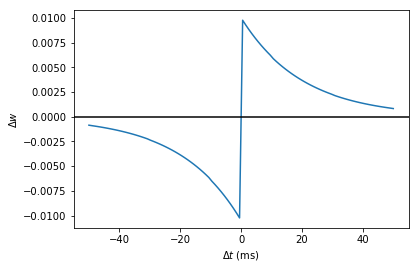

In [37]:
start_scope()

taupre = taupost = 20*ms
Apre = 0.01
Apost = -Apre*taupre/taupost*1.05
tmax = 50*ms
N = 100

# Presynaptic neurons G spike at times from 0 to tmax
# Postsynaptic neurons G spike at times from tmax to 0
# So difference in spike times will vary from -tmax to +tmax
G = NeuronGroup(N, 'tspike:second', threshold='t>tspike', refractory=100*ms)
H = NeuronGroup(N, 'tspike:second', threshold='t>tspike', refractory=100*ms)
G.tspike = 'i*tmax/(N-1)'
H.tspike = '(N-1-i)*tmax/(N-1)'

S = Synapses(G, H,
             '''
             w : 1
             dapre/dt = -apre/taupre : 1 (event-driven)
             dapost/dt = -apost/taupost : 1 (event-driven)
             ''',
             on_pre='''
             apre += Apre
             w = w+apost
             ''',
             on_post='''
             apost += Apost
             w = w+apre
             ''')
S.connect(j='i')

run(tmax+1*ms)

plot((H.tspike-G.tspike)/ms, S.w)
xlabel(r'$\Delta t$ (ms)')
ylabel(r'$\Delta w$')
axhline(0, ls='-', c='k');

# Part 3 : Simulation

## Multiple run 

Let’s start by looking at a very common task: doing multiple runs of a simulation with some parameter that changes. Let’s start off with something very simple, how does the firing rate of a leaky integrate-and-fire neuron driven by Poisson spiking neurons change depending on its membrane time constant? Let’s set that up.


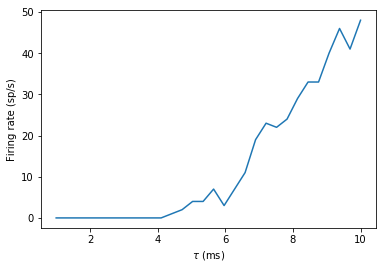

In [38]:
start_scope()
# Parameters
num_inputs = 100
input_rate = 10*Hz
weight = 0.1
# Range of time constants
tau_range = linspace(1, 10, 30)*ms
# Use this list to store output rates
output_rates = []
# Iterate over range of time constants
for tau in tau_range:
    # Construct the network each time
    P = PoissonGroup(num_inputs, rates=input_rate)
    eqs = '''
    dv/dt = -v/tau : 1
    '''
    G = NeuronGroup(1, eqs, threshold='v>1', reset='v=0', method='exact')
    S = Synapses(P, G, on_pre='v += weight')
    S.connect()
    M = SpikeMonitor(G)
    # Run it and store the output firing rate in the list
    run(1*second)
    output_rates.append(M.num_spikes/second)
# And plot it
plot(tau_range/ms, output_rates)
xlabel(r'$\tau$ (ms)')
ylabel('Firing rate (sp/s)');


We store a copy of the state of the network before the loop, and restore it at the beginning of each iteration ==> Faster to run



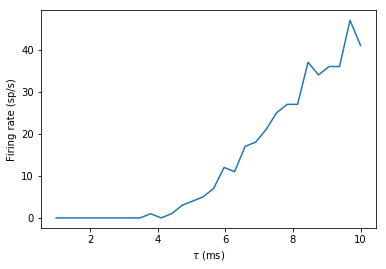

In [39]:
start_scope()
num_inputs = 100
input_rate = 10*Hz
weight = 0.1
tau_range = linspace(1, 10, 30)*ms
output_rates = []
# Construct the network just once
P = PoissonGroup(num_inputs, rates=input_rate)
eqs = '''
dv/dt = -v/tau : 1
'''
G = NeuronGroup(1, eqs, threshold='v>1', reset='v=0', method='exact')
S = Synapses(P, G, on_pre='v += weight')
S.connect()
M = SpikeMonitor(G)
# Store the current state of the network
store()
for tau in tau_range:
    # Restore the original state of the network
    restore()
    # Run it with the new value of tau
    run(1*second)
    output_rates.append(M.num_spikes/second)
plot(tau_range/ms, output_rates)
xlabel(r'$\tau$ (ms)')
ylabel('Firing rate (sp/s)');

You can also see that the output curve is very noisy and doesn’t increase monotonically like we’d expect. The noise is coming from the fact that we run the Poisson group afresh each time. If we only wanted to see the effect of the time constant, we could make sure that the spikes were the same each time (although note that really, you ought to do multiple runs and take an average). We do this by running just the Poisson group once, recording its spikes, and then creating a new SpikeGeneratorGroup that will output those recorded spikes each time.




In [ ]:
start_scope()
num_inputs = 100
input_rate = 10*Hz
weight = 0.1
tau_range = linspace(1, 10, 30)*ms
output_rates = []
# Construct the Poisson spikes just once
P = PoissonGroup(num_inputs, rates=input_rate)
MP = SpikeMonitor(P)
# We use a Network object because later on we don't
# want to include these objects
net = Network(P, MP)
net.run(1*second)
# And keep a copy of those spikes
spikes_i = MP.i
spikes_t = MP.t
# Now construct the network that we run each time
# SpikeGeneratorGroup gets the spikes that we created before
SGG = SpikeGeneratorGroup(num_inputs, spikes_i, spikes_t)
eqs = '''
dv/dt = -v/tau : 1
'''
G = NeuronGroup(1, eqs, threshold='v>1', reset='v=0', method='exact')
S = Synapses(SGG, G, on_pre='v += weight')
S.connect()
M = SpikeMonitor(G)
# Store the current state of the network
net = Network(SGG, G, S, M)
net.store()
for tau in tau_range:
    # Restore the original state of the network
    net.restore()
    # Run it with the new value of tau
    net.run(1*second)
    output_rates.append(M.num_spikes/second)
plot(tau_range/ms, output_rates)
xlabel(r'$\tau$ (ms)')
ylabel('Firing rate (sp/s)');

The input spikes are the same each time, meaning we’re seeing the effect of the time constant, not the random spikes.

Note that in the code above, we created Network objects. The reason is that in the loop, if we just called run it would try to simulate all the objects, including the Poisson neurons P, and we only want to run that once. We use Network to specify explicitly which objects we want to include.

The techniques we’ve looked at so far are the conceptually most simple way to do multiple runs, but not always the most efficient. Since there’s only a single output neuron in the model above, we can simply duplicate that output neuron and make the time constant a parameter of the group.

WARNING    "tau" is an internal variable of group "neurongroup_3", but also exists in the run namespace with the value 5. * msecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


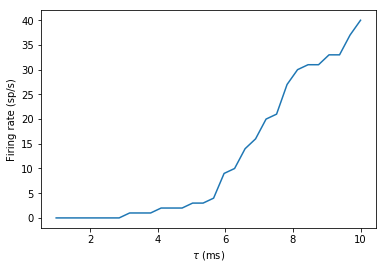

In [10]:
start_scope()
num_inputs = 100
input_rate = 10*Hz
weight = 0.1
tau_range = linspace(1, 10, 30)*ms
num_tau = len(tau_range)
P = PoissonGroup(num_inputs, rates=input_rate)
# We make tau a parameter of the group
eqs = '''
dv/dt = -v/tau : 1
tau : second
'''
# And we have num_tau output neurons, each with a different tau
G = NeuronGroup(num_tau, eqs, threshold='v>1', reset='v=0', method='exact')
G.tau = tau_range
S = Synapses(P, G, on_pre='v += weight')
S.connect()
M = SpikeMonitor(G)
# Now we can just run once with no loop
run(1*second)
output_rates = M.count/second # firing rate is count/duration
plot(tau_range/ms, output_rates)
xlabel(r'$\tau$ (ms)')
ylabel('Firing rate (sp/s)');

You can see that this is much faster again! It’s a little bit more complicated conceptually, and it’s not always possible to do this trick, but it can be much more efficient if it’s possible.

Let’s finish with this example by having a quick look at how the mean and standard deviation of the interspike intervals depends on the time constant.

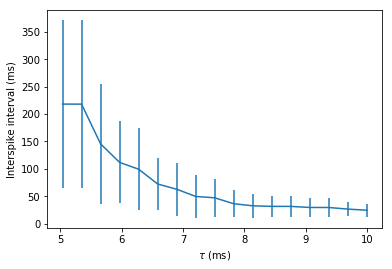

In [11]:
trains = M.spike_trains()
isi_mu = full(num_tau, nan)*second
isi_std = full(num_tau, nan)*second
for idx in range(num_tau):
    train = diff(trains[idx])
    if len(train)>1:
        isi_mu[idx] = mean(train)
        isi_std[idx] = std(train)
errorbar(tau_range/ms, isi_mu/ms, yerr=isi_std/ms)
xlabel(r'$\tau$ (ms)')
ylabel('Interspike interval (ms)');

Notice that we used the spike_trains() method of SpikeMonitor. This is a dictionary with keys being the indices of the neurons and values being the array of spike times for that neuron.


## Changing things during a run
Imagine an experiment where you inject current into a neuron, and change the amplitude randomly every 10 ms. Let’s see if we can model that using a Hodgkin-Huxley type neuron.

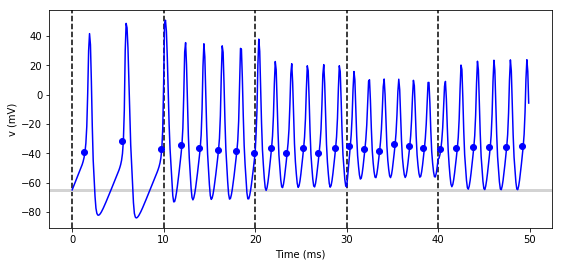

In [12]:
start_scope()
# Parameters
area = 20000*umetre**2
Cm = 1*ufarad*cm**-2 * area
gl = 5e-5*siemens*cm**-2 * area
El = -65*mV
EK = -90*mV
ENa = 50*mV
g_na = 100*msiemens*cm**-2 * area
g_kd = 30*msiemens*cm**-2 * area
VT = -63*mV
# The model
eqs_HH = '''
dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I)/Cm : volt
dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
    (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
    (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
    (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
I : amp
'''
group = NeuronGroup(1, eqs_HH,
                    threshold='v > -40*mV',
                    refractory='v > -40*mV',
                    method='exponential_euler')
group.v = El
statemon = StateMonitor(group, 'v', record=True)
spikemon = SpikeMonitor(group, variables='v')
figure(figsize=(9, 4))
for l in range(5):
    group.I = rand()*50*nA
    run(10*ms)
    axvline(l*10, ls='--', c='k')
axhline(El/mV, ls='-', c='lightgray', lw=3)
plot(statemon.t/ms, statemon.v[0]/mV, '-b')
plot(spikemon.t/ms, spikemon.v/mV, 'ob')
xlabel('Time (ms)')
ylabel('v (mV)');

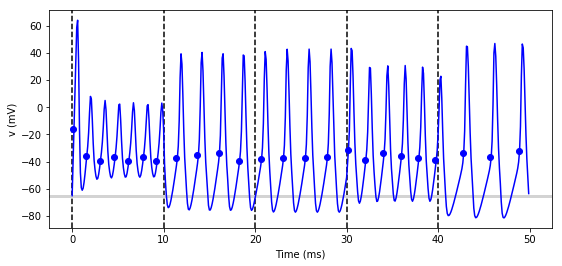

In [13]:
start_scope()
group = NeuronGroup(1, eqs_HH,
                    threshold='v > -40*mV',
                    refractory='v > -40*mV',
                    method='exponential_euler')
group.v = El
statemon = StateMonitor(group, 'v', record=True)
spikemon = SpikeMonitor(group, variables='v')
# we replace the loop with a run_regularly
group.run_regularly('I = rand()*50*nA', dt=10*ms)
run(50*ms)
figure(figsize=(9, 4))
# we keep the loop just to draw the vertical lines
for l in range(5):
    axvline(l*10, ls='--', c='k')
axhline(El/mV, ls='-', c='lightgray', lw=3)
plot(statemon.t/ms, statemon.v[0]/mV, '-b')
plot(spikemon.t/ms, spikemon.v/mV, 'ob')
xlabel('Time (ms)')
ylabel('v (mV)');

Now let’s extend this example to run on multiple neurons, each with a different capacitance to see how that affects the behaviour of the cell.



Text(0,0.5,'v (mV)')

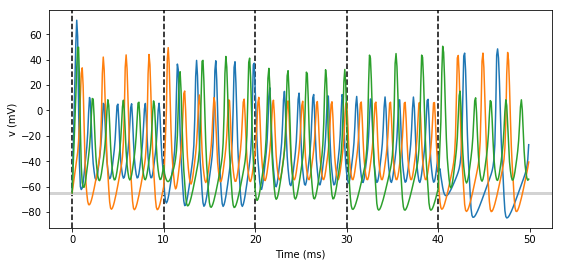

In [14]:
start_scope()
N = 3
eqs_HH_2 = '''
dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I)/C : volt
dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
    (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
    (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
    (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
I : amp
C : farad
'''
group = NeuronGroup(N, eqs_HH_2,
                    threshold='v > -40*mV',
                    refractory='v > -40*mV',
                    method='exponential_euler')
group.v = El
# initialise with some different capacitances
group.C = array([0.8, 1, 1.2])*ufarad*cm**-2*area
statemon = StateMonitor(group, variables=True, record=True)
# we go back to run_regularly
group.run_regularly('I = rand()*50*nA', dt=10*ms)
run(50*ms)
figure(figsize=(9, 4))
for l in range(5):
    axvline(l*10, ls='--', c='k')
axhline(El/mV, ls='-', c='lightgray', lw=3)
plot(statemon.t/ms, statemon.v.T/mV, '-')
xlabel('Time (ms)')
ylabel('v (mV)')

So that runs, but something looks wrong! The injected currents look like they’re different for all the different neurons! Let’s check:

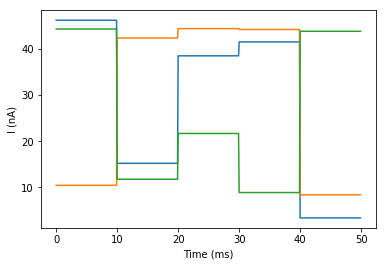

In [15]:
plot(statemon.t/ms, statemon.I.T/nA, '-')
xlabel('Time (ms)')
ylabel('I (nA)');

Sure enough, it’s different each time. But why? We wrote group.run_regularly('I = rand()*50*nA', dt=10*ms) which seems like it should give the same value of I for each neuron. But, like threshold and reset statements, run_regularly code is interpreted as being run separately for each neuron, and because I is a parameter, it can be different for each neuron. We can fix this by making I into a shared variable, meaning it has the same value for each neuron.

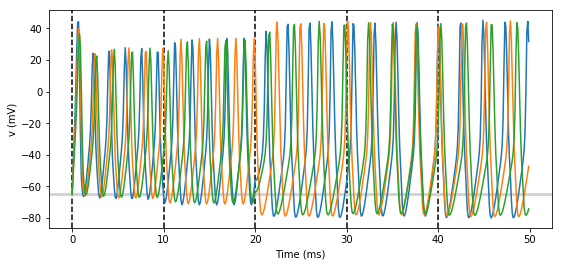

In [16]:
start_scope()
N = 3
eqs_HH_3 = '''
dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I)/C : volt
dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
    (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
    (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
    (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
I : amp (shared) # everything is the same except we've added this shared
C : farad
'''
group = NeuronGroup(N, eqs_HH_3,
                    threshold='v > -40*mV',
                    refractory='v > -40*mV',
                    method='exponential_euler')
group.v = El
group.C = array([0.8, 1, 1.2])*ufarad*cm**-2*area
statemon = StateMonitor(group, 'v', record=True)
group.run_regularly('I = rand()*50*nA', dt=10*ms)
run(50*ms)
figure(figsize=(9, 4))
for l in range(5):
    axvline(l*10, ls='--', c='k')
axhline(El/mV, ls='-', c='lightgray', lw=3)
plot(statemon.t/ms, statemon.v.T/mV, '-')
xlabel('Time (ms)')
ylabel('v (mV)');

## Addint input
Now let’s think about a neuron being driven by a sinusoidal input. Let’s go back to a leaky integrate-and-fire to simplify the equations a bit.


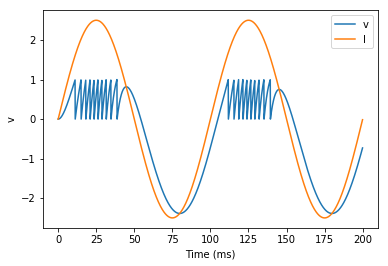

In [5]:
start_scope()
A = 2.5
f = 10*Hz
tau = 5*ms
eqs = '''
dv/dt = (I-v)/tau : 1
I = A*sin(2*pi*f*t) : 1
'''
G = NeuronGroup(1, eqs, threshold='v>1', reset='v=0', method='euler')
M = StateMonitor(G, variables=True, record=True)
run(200*ms)
plot(M.t/ms, M.v[0], label='v')
plot(M.t/ms, M.I[0], label='I')
xlabel('Time (ms)')
ylabel('v')
legend(loc='best');

Now, what if that input current were something we had recorded and saved in a file? In that case, we can use TimedArray. Let’s start by reproducing the picture above but using TimedArray.

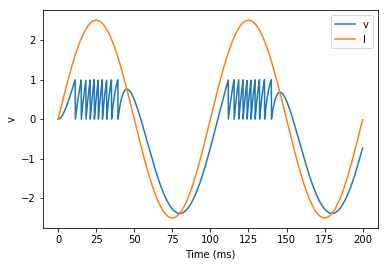

In [4]:
start_scope()
A = 2.5
f = 10*Hz
tau = 5*ms
# Create a TimedArray and set the equations to use it
t_recorded = arange(int(200*ms/defaultclock.dt))*defaultclock.dt
I_recorded = TimedArray(A*sin(2*pi*f*t_recorded), dt=defaultclock.dt)
eqs = '''
dv/dt = (I-v)/tau : 1
I = I_recorded(t) : 1
'''
G = NeuronGroup(1, eqs, threshold='v>1', reset='v=0', method='exact')
M = StateMonitor(G, variables=True, record=True)
run(200*ms)
plot(M.t/ms, M.v[0], label='v')
plot(M.t/ms, M.I[0], label='I')
xlabel('Time (ms)')
ylabel('v')
legend(loc='best');

Note that for the example where we put the sin function directly in the equations, we had to use the method='euler' argument because the exact integrator wouldn’t work here (try it!). However, TimedArray is considered to be constant over its time step and so the linear integrator can be used. This means you won’t get the same behaviour from these two methods for two reasons. Firstly, the numerical integration methods exact and euler give slightly different results. Secondly, sin is not constant over a timestep whereas TimedArray is.

Now just to show that TimedArray works for arbitrary currents, let’s make a weird “recorded” current and run it on that.

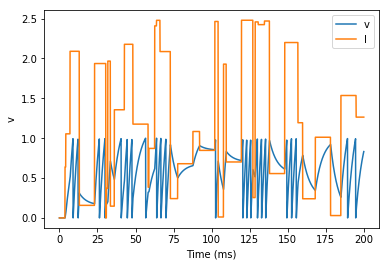

In [3]:
start_scope()
A = 2.5
f = 10*Hz
tau = 5*ms
# Let's create an array that couldn't be
# reproduced with a formula
num_samples = int(200*ms/defaultclock.dt)
I_arr = zeros(num_samples)
for _ in range(100):
    a = randint(num_samples)
    I_arr[a:a+100] = rand()
I_recorded = TimedArray(A*I_arr, dt=defaultclock.dt)
eqs = '''
dv/dt = (I-v)/tau : 1
I = I_recorded(t) : 1
'''
G = NeuronGroup(1, eqs, threshold='v>1', reset='v=0', method='exact')
M = StateMonitor(G, variables=True, record=True)
run(200*ms)
plot(M.t/ms, M.v[0], label='v')
plot(M.t/ms, M.I[0], label='I')
xlabel('Time (ms)')
ylabel('v')
legend(loc='best');

In [ ]:
i = range(5)
print(i)